# Actor-Critic - Cartpole

In the policy gradient method, we introduced the expectation of the rewards. Intuitively, the 2 components of the expectation $R(a)$ and $P(a|\pi_\theta(s))$ are independent of the actual action, so we can train the 2 components separately.
In this case, actor works to select action while critic works as evaluator of the action.
Depending on the estimated value of the critic, we have:

 - Q Actor-Critic: where the estimated value is V or Q value. 
 - Advantage Actor-Critic (A2C): here the estimated value is TD value. In this case, the advantage is denoted as:
 $$ A_{\pi_\theta} = V_{\pi_\theta}(s_{t+1}) - V_{\pi_\theta} (s_{t}) $$ 

For an episode, we can estimate the advantage with:
$$A_t = \sum \gamma r - V(s_t)$$

However, for within episode, this value can be estimated (TD(0)) as:
$$A_t = r + \gamma V(s_{t+1}) - V(s_{t})$$

In [64]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import HTML
from cartpole_utils import env_cartpole, display_frames_as_gif, goalAchieved, test_cartpole

## End of Episode

In [10]:
# networks

class ValueNet(nn.Module):
    def __init__(self):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)
    
class ActorNet(nn.Module):
    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        out = torch.relu(self.fc1(x))
        logits = self.fc2(out)
        return logits 

In [105]:
class ReplayMemory:
    def __init__(self, size=1000):
        self.games = []
        self.size = size

    def add(self, attrib:list, control=False):
        if len(self) > self.size and control:
            self.games.pop(0)
        self.games.append(attrib)
        
    def __len__(self):
        return len(self.games)
    
    def clear(self):
        self.games.clear()
    
    def sample(self, batch_size=None, shuffle=False):
        if shuffle and batch_size is not None:
            samples = random.sample(self.games, batch_size)
        elif not shuffle and batch_size is not None:
            samples = self.games[-batch_size:]
        else:
            samples = self.games
        out = []
        for i in range(len(samples[0])):
            tensor = torch.tensor([items[i] for items in samples])
            out.append(tensor)
        return out

In [12]:
class A2CAgent:
    def __init__(self):
        self.value_net = ValueNet()
        self.actor_net = ActorNet()
        self.opt_value = torch.optim.AdamW(self.value_net.parameters(), lr=0.001)
        self.opt_actor= torch.optim.AdamW(self.actor_net.parameters(), lr=0.001)

    def act(self, state, train=True):
        if isinstance(state, np.ndarray):
            if len(state.shape) == 1:
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            else:
                state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            probs = F.softmax(self.actor_net(state), dim=-1).detach()
            action = torch.multinomial(probs, 1).item()
        return action
    
    def learn(self, plays):
        def cum_reward(rewards, gamma=0.99):
            cum_rewards = torch.zeros_like(rewards).to(torch.float32)
            for j in range(len(rewards))[::-1]:
                cum_rewards[j] = rewards[j] + gamma * (cum_rewards[j+1] if j+1<len(rewards) else 0)
            eps = np.finfo(np.float32).eps.item()
            cum_rewards = (cum_rewards - cum_rewards.mean()) / (cum_rewards.std() + eps)
            return cum_rewards

        # get data
        samples = plays.sample()
        
        # get samples batch
        states, rewards, actions,_ = samples

        # compute cumulated reward
        rewards_cum = cum_reward(rewards)

        # critic
        values = self.value_net(states).squeeze()
        vloss = F.mse_loss(values, rewards_cum, reduction='sum')
        self.opt_value.zero_grad()
        vloss.backward()
        self.opt_value.step()

        # actor
        with torch.no_grad():
            values = self.value_net(states).detach()
        advantages = rewards_cum - values
        
        logits = self.actor_net(states)
        # Cross-entropy loss is -log P in categorical distribution.
        log_probs = F.cross_entropy(logits, actions, reduction='none')
        aloss = (log_probs * advantages).sum()
        self.opt_actor.zero_grad()
        aloss.backward()
        self.opt_actor.step()

        return vloss.detach().item(), aloss.detach().item()

In [13]:
# train loop

epochs = 1000
state_num = 4 # 
action_num = 2
memory = ReplayMemory()
agent = A2CAgent()

scores = []
vlosses, alosses = [], []

for e in range(epochs):
    # reset environment
    state, _ = env_cartpole.reset()

    currState = state
    done = False

    score = 0
    tot_loss = 0
    count = 0

    # run an episode
    while not done :
        
        # choose action
        action = agent.act(state)

        # take action on env
        state, reward, done, info, _ = env_cartpole.step(action)
        
        # add to replay memory
        memory.add([currState, reward, action, done])

        currState = state.copy()

        # update score
        score += 1

        if score > 800:
            break
    
    # train
    vloss, aloss = agent.learn(memory)

    # clear memory
    memory.clear()
    
    scores = np.append(scores, score)
    vlosses = np.append(vlosses, vloss)
    alosses = np.append(alosses, aloss)

    if (e+1)%100 == 0:
        print(f"epoche: {e+1}, score: {score}, value loss: {vloss:.6f}, actor loss: {aloss:.6f}")
    if goalAchieved(scores):
        break

epoche: 100, score: 22, value loss: 13.873500, actor loss: 39.112457
epoche: 200, score: 116, value loss: 45.534241, actor loss: 3352.115723
epoche: 300, score: 146, value loss: 29.623028, actor loss: -1318.869995
epoche: 400, score: 301, value loss: 19.074909, actor loss: -4446.641602
epoche: 500, score: 281, value loss: 26.542641, actor loss: 8376.466797


In [14]:
frames = test_cartpole(env_cartpole, 300, agent=agent)
anim = display_frames_as_gif(frames)
HTML(anim.to_jshtml())

/home/niuniu/Documents/RL/env_rl/lib64/python3.13/site-packages/gymnasium/envs/classic_control/cartpole.py:214: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


289


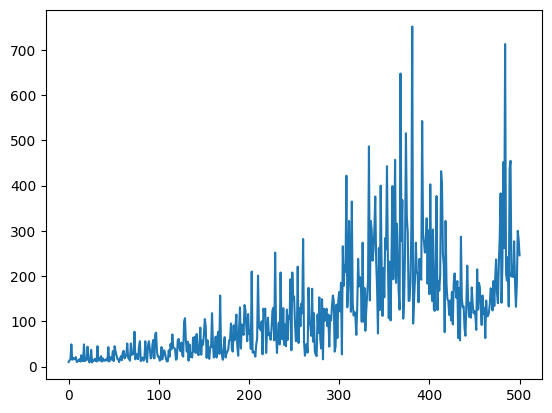

In [15]:
plt.plot(scores)

## In Episode

In [115]:
class A2CInAgent():
    def __init__(self):
        self.value_net = ValueNet()
        self.actor_net = ActorNet()
        self.opt_value = torch.optim.Adam(self.value_net.parameters(), lr=0.001)
        self.opt_actor= torch.optim.Adam(self.actor_net.parameters(), lr=0.001)

    def act(self, state, train=True):
        if isinstance(state, np.ndarray):
            if len(state.shape) == 1:
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            else:
                state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            probs = F.softmax(self.actor_net(state), dim=-1).detach()
            action = torch.multinomial(probs, 1).item()
        return action
        
    def learn(self, plays: ReplayMemory, batch_size=128, shuffle=False):
        def cum_reward(rewards, gamma=0.99):
            cum_rewards = torch.zeros_like(rewards).to(torch.float32)
            for j in range(len(rewards))[::-1]:
                cum_rewards[j] = rewards[j] + gamma * (cum_rewards[j+1] if j+1<len(rewards) else 0)
            eps = np.finfo(np.float32).eps.item()
            cum_rewards = (cum_rewards - cum_rewards.mean()) / (cum_rewards.std() + eps)
            return cum_rewards

        # get data
        samples = plays.sample(batch_size=batch_size, shuffle=shuffle)
        
        # get samples batch
        states, rewards, actions, nextstates, dones = samples

        # critic
        values = self.value_net(states)
        with torch.no_grad():
            next_values = self.value_net(nextstates)
        estimate = rewards.unsqueeze(-1) + 0.99 * next_values * (1.0-dones).unsqueeze(-1)
        vloss = F.mse_loss(values, estimate, reduction='mean')
        self.opt_value.zero_grad()
        vloss.backward()
        self.opt_value.step()

        # actor
        with torch.no_grad():
            values = self.value_net(states).detach()
            
        advantages = estimate - values
        
        logits = self.actor_net(states)
        # Cross-entropy loss is -log P in categorical distribution.
        log_probs = F.cross_entropy(logits, actions, reduction='none')
        aloss = (log_probs * advantages).mean()
        self.opt_actor.zero_grad()
        aloss.backward()
        self.opt_actor.step()

        return vloss.detach().item(), aloss.detach().item()

In [124]:
# train loop

epochs = 2000
state_num = 4 # 
action_num = 2
batch_size = 1
memory = ReplayMemory(1)
agent = A2CInAgent()

scores = []
vlosses, alosses = [], []


for e in range(epochs):
    # reset environment
    state, _ = env_cartpole.reset()

    currState = state
    done = False

    score = 0
    tot_vloss = 0
    tot_aloss = 0
    count = 0

    # run an episode
    while not done :
        
        # choose action
        action = agent.act(state)

        # take action on env
        state, reward, done, info, _ = env_cartpole.step(action)

        done = 1 if done is True else 0
        
        # add to replay memory
        memory.add([currState, reward, action, state, done], control=True)

        # train
        if len(memory) >= batch_size:
            vloss, aloss = agent.learn(memory, batch_size=batch_size, shuffle=True)

            tot_vloss += vloss
            tot_aloss += aloss
            count += 1

        currState = state.copy()

        # update score
        score += 1

        if score > 800:
            break
    

    scores = np.append(scores, score)
    vlosses = np.append(vlosses, tot_vloss/count if count>0 else 0)
    alosses = np.append(alosses, tot_aloss/count if count>0 else 0)

    if (e+1)%100 == 0:
        print(f"epoche: {e+1}, score: {score}, value loss: {vlosses[-1]:.6f}, actor loss: {alosses[-1]:.6f}")
    if goalAchieved(scores):
        break

/tmp/ipykernel_28317/1170014922.py:25: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  cum_rewards = (cum_rewards - cum_rewards.mean()) / (cum_rewards.std() + eps)


epoche: 100, score: 9, value loss: 0.847775, actor loss: 0.033399
epoche: 200, score: 35, value loss: 18.684310, actor loss: 0.011267
epoche: 300, score: 50, value loss: 20.272525, actor loss: 0.059002
epoche: 400, score: 126, value loss: 6.853464, actor loss: -0.190310
epoche: 500, score: 188, value loss: 0.071331, actor loss: 0.011501
epoche: 600, score: 438, value loss: 4.910849, actor loss: -0.007775


In [119]:
frames = test_cartpole(env_cartpole, 300, agent=agent)
anim = display_frames_as_gif(frames)
HTML(anim.to_jshtml())

301


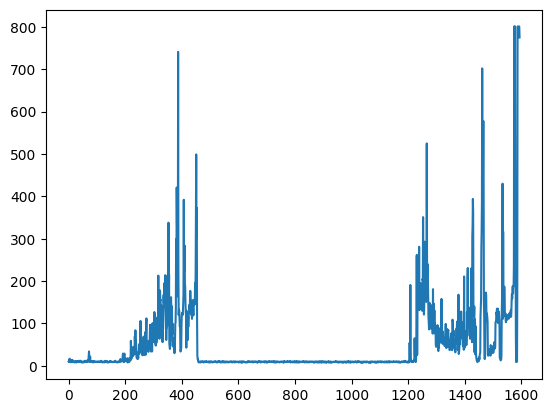

In [120]:
plt.plot(scores)

# doc
 - https://arxiv.org/pdf/1506.02438
 - https://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_5_actor_critic_pdf.pdf